# Causal Interpretation for Ames Housing Price

This notebook uses the Ames Housing dataset to showcase how we can interpret a blackbox model from both the **correlation and causation** perspective by leveraging the power of model interpretation tools like [SHAP](https://shap.readthedocs.io/en/latest/index.html) and [EconML](https://aka.ms/econml). This housing dataset collects house prices and characteristics for homes sold in Ames, Iowa from the period of 2006 to 2010. We start with a linear regression to build intuition. We then train a fine-tuned predictive ML model and use SHAP to better understand the correlations between features and target and which features are the strongest predictors. Finally, we train a separate causal model using EconML, which identifies features that have a **direct causal effect** on housing price, instead of just predicting the housing price given a set of characteristics.

Note: A previous version of this notebook used the Boston Housing dataset. Due to ethical concerns with the Boston Housing dataset, we have decided to redo the analysis on the similar Ames Housing dataset. More details can be found on the sklearn page for the [Boston Housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html).

This notebook includes the following sections:
1. [A Gentle Start: Linear Regression](#A-Gentle-Start:-Linear-Regression)
2. [Train a Fine-tuned Predictive ML Model](#Train-a-Fine-tuned-Predictive-ML-Model)
3. [Correlation Interpretation](#Correlation-Interpretation)
    * Feature Importance -- Learn the top predictors for a given ML model
4. [Causal Interpretation](#Causal-Interpretation)
    * Direct Causal Effect -- Do certain house amentiies have a direct effect on home value?
    * Segmentation -- How do different type of houses respond differently to having a fireplace?
    * Policy Analysis -- What is the best policy considering cost?
    * What If Analysis -- How does the overall housing price change if every home had a fireplace?
    * Cohort Analysis -- What is the causal effect on a new dataset?
    

In [1]:
# Some imports to get us started
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import shap

%matplotlib inline

# A Gentle Start: Linear Regression

### Data Description

The data contain features of Ames homes sold between 2006 and 2010 and was originally introduced by Dean De Cock. [Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project](http://jse.amstat.org/v19n3/decock.pdf), Journal of Statistics Education Volume 19, Number 3(2011)

Below is a sample of the features and their descriptions:

Feature Name|Description
:--- |:---
**Neighborhood**|Physical locations within Ames city limits
**BsmtFullBath**|Basement full bathrooms
**Alley**|Type of alley access to property
**BsmtFinType1**|Rating of basement finished area
**Fence**|Fence quality
**MiscFeature**|Miscellaneous feature not covered in other categories
**RoofStyle**|Type of roof
**GrLivArea**|Above grade (ground) living area square feet
**SalePrice**|Sale price of home

A more complete data dictionary can be found on the [OpenML page for the dataset](https://www.openml.org/d/42165).

We start with a linear regression to learn the conditional correlation between each predictor and the outcome variable. The coefficients  tell us how the housing price will change with one unit increase of each feature (holding all other features constant), and the p-value tells us the variable significance.

Under certain strong assumptions, the coefficients from linear regression can lead us to a causal interpretation too. But as we will see later in this notebook, techniques like DoubleML can allow us to use the predictive power of machine learning to do causal inference while also minimizing assumptions about the functional form of our data (e.g. additive separability).

In [2]:
from sklearn.datasets import fetch_openml

ames_housing = fetch_openml(name="house_prices", as_frame = True)

In [3]:
ames_df = ames_housing.data
print(ames_df.shape)

(1460, 80)


#### Data processing

Minor feature engineering via feature creation/removal, and outlier removal

In [4]:
Xy = (
    ames_df
    .assign(SalePrice = ames_housing.target) # add target feature
    .set_index('Id')
    .loc[
        lambda df: df['MasVnrType'].notna() # drop outliers with missing detail in this column
    ]
    .loc[
        lambda df: df['Electrical'].notna() # drop outlier with missing electrical row
    ]
    .assign(
        AgeAtSale = lambda df: df['YrSold'].sub(df['YearBuilt']), # add interpretable year columns
        YearsSinceRemodel = lambda df: df['YrSold'].sub(df['YearRemodAdd']).clip(lower = 0), # clip lower for outlier
        
        HasDeck = lambda df: df['WoodDeckSF'].gt(0).map(int),
        HasPorch = lambda df: 
        df[['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']]
        .gt(0)
        .max(axis = 1)
        .map(int),
        
        HasFireplace = lambda df: df['Fireplaces'].clip(upper = 1).map(int),
        HasFence = lambda df: df['Fence'].notna().map(int)
    )
    
    # drop year columns
    .drop(
        columns = [
            'GarageYrBlt', 'YearBuilt', 'YrSold', 'YearRemodAdd', 
            'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
            'FireplaceQu', 'Fireplaces'
        ]
    ) 
    .assign(LotFrontage = lambda df: df['LotFrontage'].fillna(0)) # fill missing with 0
    .fillna('NA') # rest of missing values are in categorical columns, so fill with NA category
    .assign(Intercept = 1) # add constant column for OLS
)

Xy

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SaleType,SaleCondition,SalePrice,AgeAtSale,YearsSinceRemodel,HasDeck,HasPorch,HasFireplace,HasFence,Intercept
Id,,,,,,,,,,,,,,,,,,,,,
1.0,60.0,RL,65.0,8450.0,Pave,NA,Reg,Lvl,AllPub,Inside,...,WD,Normal,208500.0,5.0,5.0,0,1,0,0,1
2.0,20.0,RL,80.0,9600.0,Pave,NA,Reg,Lvl,AllPub,FR2,...,WD,Normal,181500.0,31.0,31.0,1,0,1,0,1
3.0,60.0,RL,68.0,11250.0,Pave,NA,IR1,Lvl,AllPub,Inside,...,WD,Normal,223500.0,7.0,6.0,0,1,1,0,1
4.0,70.0,RL,60.0,9550.0,Pave,NA,IR1,Lvl,AllPub,Corner,...,WD,Abnorml,140000.0,91.0,36.0,0,1,1,0,1
5.0,60.0,RL,84.0,14260.0,Pave,NA,IR1,Lvl,AllPub,FR2,...,WD,Normal,250000.0,8.0,8.0,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456.0,60.0,RL,62.0,7917.0,Pave,NA,Reg,Lvl,AllPub,Inside,...,WD,Normal,175000.0,8.0,7.0,0,1,1,0,1
1457.0,20.0,RL,85.0,13175.0,Pave,NA,Reg,Lvl,AllPub,Inside,...,WD,Normal,210000.0,32.0,22.0,1,0,1,1,1
1458.0,70.0,RL,66.0,9042.0,Pave,NA,Reg,Lvl,AllPub,Inside,...,WD,Normal,266500.0,69.0,4.0,0,1,1,1,1


In [5]:
# identify categorical columns for one hot encoding
categorical = list(
    Xy
    .apply(lambda series: series.dtype)
    .loc[
        lambda df: df.eq('object')
    ]
    .index
) + ['MSSubClass']


In [6]:
X = Xy.drop(columns = 'SalePrice')
X_ohe = (
    X
    .pipe(pd.get_dummies, prefix_sep = '_OHE_', columns = categorical)
)
y = Xy['SalePrice']

In [7]:
# Train a linear regression using statsmodels
model = sm.OLS(y, X_ohe)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     65.23
Date:                Mon, 04 Apr 2022   Prob (F-statistic):               0.00
Time:                        15:07:09   Log-Likelihood:                -16473.
No. Observations:                1451   AIC:                         3.345e+04
Df Residuals:                    1197   BIC:                         3.480e+04
Df Model:                         253                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
LotFrontage                   4.3143     23.148      0.186      0.852     -41.101      49.729
LotArea                       0.7546      0.109      6.901      0.000       0.540       0.969
OverallQual                6360.2220   1040.396      6.113      0.000    4319.020    8401.424
OverallCond                5821.8514    874.831      6.655      0.000    4105.480    7538.223
MasVnrArea                   23.4430      5.850      4.008      0.000      11.966      34.920
BsmtFinSF1                   16.5511      2.910      5.688      0.000      10.842      22.260
BsmtFinSF2                    8.6634      5.994      1.445      0.149      -3.096      20.423
BsmtUnfSF                    -1.9481      2.773     -0.703      0.482      -7.389       3.492
TotalBsmtSF                  23.2663      4.081      5.701      0.000      15.259      31.273
1stFlrSF                     20.1076      6.532      3.079      0.002       7.293      32.922
2ndFlrSF                     36.9338      5.494      6.723      0.000      26.156      47.712
LowQualFinSF                -31.0995     14.117     -2.203      0.028     -58.797      -3.402
GrLivArea                    25.9420      5.777      4.490      0.000      14.607      37.277
BsmtFullBath               1562.1546   1990.510      0.785      0.433   -2343.122    5467.431
BsmtHalfBath               -313.6252   3038.274     -0.103      0.918   -6274.561    5647.311
FullBath                   3395.1065   2232.024      1.521      0.129    -984.008    7774.221
HalfBath                   1491.1384   2114.192      0.705      0.481   -2656.797    5639.074
BedroomAbvGr              -3167.5337   1415.101     -2.238      0.025   -5943.889    -391.178
KitchenAbvGr              -9959.5368   6277.750     -1.586      0.113   -2.23e+04    2357.080
TotRmsAbvGrd               1524.9555    966.910      1.577      0.115    -372.071    3421.981
GarageCars                 4222.4167   2290.287      1.844      0.065    -271.007    8715.841
GarageArea                   17.1483      7.667      2.237      0.025       2.106      32.191
PoolArea                    555.6536    226.407      2.454      0.014     111.454     999.853
MiscVal                       3.0466      6.354      0.479      0.632      -9.419      15.512
MoSold                     -450.7674    245.780     -1.834      0.067    -932.976      31.441
AgeAtSale                  -310.1254     80.940     -3.832      0.000    -468.926    -151.324
YearsSinceRemodel           -98.1576     55.507     -1.768      0.077    -207.059      10.744
HasDeck                    2214.5455   1496.643      1.480      0.139    -721.789    5150.880
HasPorch                   2445.8491   1659.415      1.474      0.141    -809.836    5701.534
HasFireplace               1707.7901   1723.045      0.991      0.322   -16

# Train a Fine-tuned Predictive ML Model

Now we train a LightGBM regression model and use grid search to do model tuning.

In [8]:
# Split data into train and test
from sklearn.model_selection import train_test_split

x_train_ohe, x_test_ohe, x_train, x_test, y_train, y_test = train_test_split(
    X_ohe, X, y, test_size=0.2, random_state=0
)

In [9]:
# train a lightGBM regression model
est = LGBMRegressor()
param_grid = {"learning_rate": [0.1, 0.05, 0.01], "max_depth": [3, 5, 10]}
search = GridSearchCV(est, param_grid, n_jobs=-1)

In [10]:
search.fit(x_train_ohe, y_train)
print("Best estimator: ", search.best_params_)

Best estimator:  {'learning_rate': 0.1, 'max_depth': 3}


In [11]:
print("Test set score: ", search.best_estimator_.score(x_test_ohe, y_test))

Test set score:  0.9012812671965527


# Correlation Interpretation
### Feature Importance - Shap Value
We explain this ML model by understanding the top important features to predict the housing price, internally using **shap value**.

In [12]:
fitted_model = search.best_estimator_

In [13]:
# use interventional approach
background = shap.maskers.Independent(x_train_ohe, max_samples=1000)
explainer = shap.TreeExplainer(
    fitted_model, data=background, feature_names=X_ohe.columns
)
shap_values = explainer(x_test_ohe)

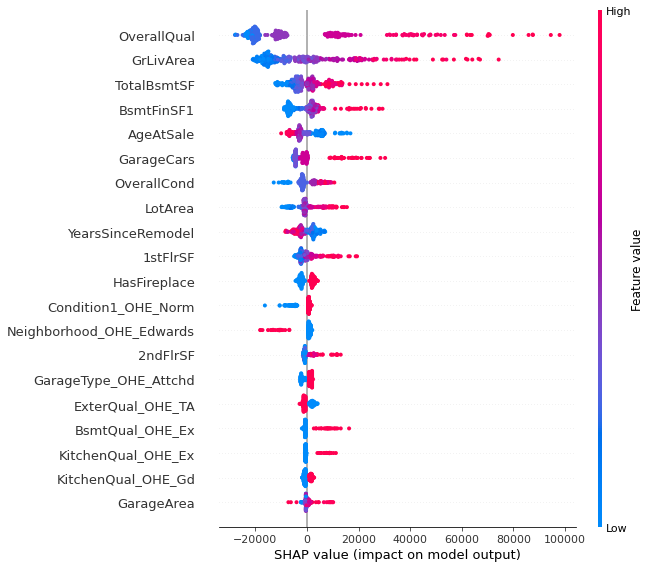

In [14]:
# plot the feature importance
shap.summary_plot(shap_values, x_test_ohe)

From the summary plot above, we could see the **most important features** sorted by their importance level. It tells us that houses that measure high in overall quality, square footage, and are also relatively new will have a higher housing price. 

# Causal Interpretation
### Direct Causal Effect --  Do certain house amenities have a direct effect on home value?

In [15]:
from econml.solutions.causal_analysis import CausalAnalysis

# initialize heterogeneity features
hetero_cols = ['AgeAtSale', 'MSZoning']
ca = CausalAnalysis(
    feature_inds= [
        'HasFireplace',
        'HasPorch',
        'HasDeck',
    ],
    categorical = categorical + ['HasFireplace', 'HasPorch', 'HasDeck', 'HasFence'],
    heterogeneity_inds=hetero_cols,
    classification=False,
    nuisance_models="automl",
    heterogeneity_model="linear",
    n_jobs=-1,
    random_state=123,
    upper_bound_on_cat_expansion=6
)
ca.fit(x_train, y_train)

In [16]:
# get global causal effect ordered by causal importance (pvalue)
global_summ = ca.global_causal_effect(alpha=0.05)
global_summ.sort_values(by="p_value")

,point,stderr,zstat,p_value,ci_lower,ci_upper
feature,,,,,,
HasFireplace,4747.946548,1501.780424,3.161545,0.001569,1804.511004,7691.382093
HasPorch,3841.739431,2203.376126,1.743570,0.081234,-476.798421,8160.277282
HasDeck,1496.066737,1829.366971,0.817806,0.413468,-2089.426640,5081.560114


In [17]:
# helper function to plot error bar
def errorbar(res):
    xticks = res.index.get_level_values(0)
    lowererr = res["point"] - res["ci_lower"]
    uppererr = res["ci_upper"] - res["point"]
    xticks = [
        "{}***".format(t)
        if p < 1e-6
        else ("{}**".format(t) if p < 1e-3 else ("{}*".format(t) if p < 1e-2 else t))
        for t, p in zip(xticks, res["p_value"])
    ]
    plot_title = "Direct Causal Effect of Each Feature with 95% Confidence Interval, "
    plt.figure(figsize=(15, 5))
    plt.errorbar(
        np.arange(len(xticks)),
        res["point"],
        yerr=[lowererr, uppererr],
        fmt="o",
        capsize=5,
        capthick=1,
        barsabove=True,
    )
    plt.xticks(np.arange(len(xticks)), xticks, rotation=45)
    plt.title(plot_title)
    plt.axhline(0, color="r", linestyle="--", alpha=0.5)
    plt.ylabel("Average Treatment Effect")

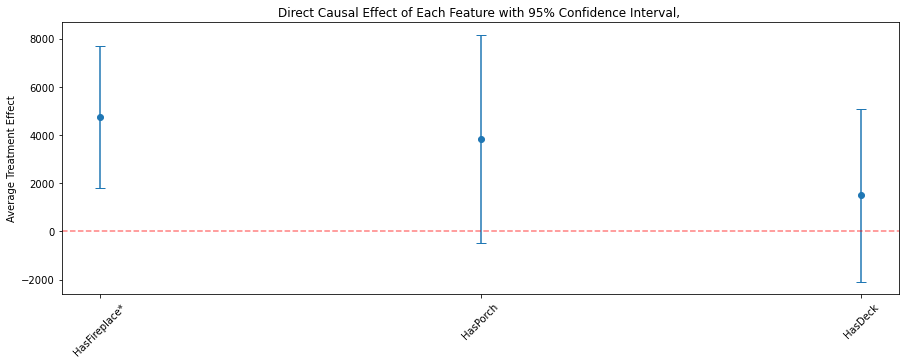

In [18]:
errorbar(global_summ)

We learn the **Average Treatment Effect (ATE)** for certain house amenities (e.g. having a fireplace), assuming they are the treatment. The error bar above is ordered by **feature importance**, and the summary table above is ordered by **causal significance (p-value)**. Coincidentally, they are in the exact same order.

### Segmentation -- How do different type of houses respond differently to having a fireplace?
From the analysis above, we learned the direct effect of a few different house amenities on housing price at an average level. However, the effect of these house amenities on house price may vary by features like home age and zoning classification. In the following section, we are going to use the presence of a fireplace as an example to learn how different type of houses may increase in value with the addition of a fireplace. 

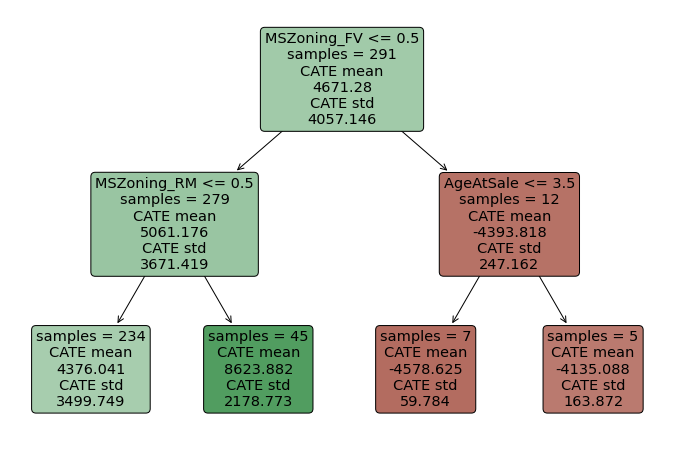

In [19]:
plt.figure(figsize=(12, 8))
ca.plot_heterogeneity_tree(
    x_test,
    "HasFireplace",
    max_depth=2,
    min_impurity_decrease=1e-6,
    min_samples_leaf = 5
)

From the global level, we know that the ATE of having a porch is 4.7k, which means on average that having a porch will raise the housing price by $4.7k. In the shallow tree above, we can see although overall porches already have a positive effect on housing price, the effect is even more dramatic on housing price in houses in medium density residential zones (i.e. when MSZoning is RM)

### Policy Analysis -- What is the best policy considering cost?
To take a step further, we'd like to know the sub-population where the treatment effect will still be positive after taking cost into consideration. Assuming the average cost of adding a fireplace is $3,000, let us see what kind of houses have a housing price that will increase more than their cost.  

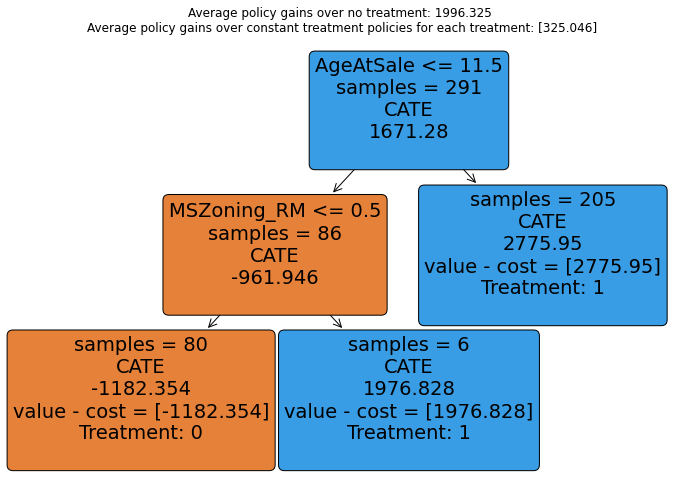

In [20]:
plt.figure(figsize=(12, 8))
ca.plot_policy_tree(
    x_test,
    "HasFireplace",
    treatment_costs=3000,
    max_depth=2,
    min_samples_leaf = 5
)

You could see if we follow the recommended policy above, on average, the housing price will increase by \\$1,996 compared with no fireplace added. Similarly, it will increase by \\$325 compared with adding a fireplace for every house. To be more detailed, we could also output the individualized policy. In the following table, we will only print the top five houses ordered by policy gains.

In [21]:
ca.individualized_policy(
    x_test,
    "HasFireplace",
    n_rows=5,
    treatment_costs=3000,
    alpha=0.1,
)

,Treatment,Effect of treatment,Effect of treatment lower bound,Effect of treatment upper bound,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,...,MoSold,SaleType,SaleCondition,AgeAtSale,YearsSinceRemodel,HasDeck,HasPorch,Current treatment,HasFence,Intercept
Id,,,,,,,,,,,,,,,,,,,,,
1350.0,1,9930.010581,961.975260,18898.045902,70.0,RM,50.0,5250.0,Pave,Pave,...,12.0,WD,Normal,136.0,21.0,0,1,0,0,1
1063.0,1,8178.296988,1486.232093,14870.361883,190.0,RM,85.0,13600.0,Pave,Grvl,...,9.0,WD,Normal,107.0,57.0,0,1,0,0,1
243.0,1,8117.893071,1497.502121,14738.284022,50.0,RM,63.0,5000.0,Pave,NA,...,4.0,WD,Normal,106.0,56.0,0,1,0,0,1
199.0,1,7574.257818,1568.693952,13579.821684,75.0,RM,92.0,5520.0,Pave,NA,...,7.0,WD,Abnorml,97.0,59.0,0,1,0,1,1
410.0,0,7569.996006,-4455.476195,19595.468207,60.0,FV,85.0,10800.0,Pave,NA,...,4.0,New,Partial,1.0,0.0,0,1,1,0,1


Note that here the `effect of treatment` is the treatment effect of selecting one of the discrete treatment values minus the cost. In the treament column, 1 corresponds to having a fireplace, and 0 corresponds to no fireplace.

### What If Analysis - How does the overall housing price change if every home had a fireplace?
The causal analysis tool could also answer **what if** types of questions. For a given treatment, we'd also like to know the **counterfactuals** if we intervene it in a different way. In the example below, we will learn how the overall housing price changes if every house in Ames had a fireplace.

In [22]:
whatif_df = (
    x_test
    .loc[
        lambda df: df['HasFireplace'].eq(0)
    ]
)
whatif_y = y_test.loc[whatif_df.index]

cf = ca.whatif(
    whatif_df, 
    whatif_df['HasFireplace'].add(1).clip(upper = 1), 
    'HasFireplace', 
    whatif_y)
print("Current average housing price on test set: ", whatif_y.mean())
print(
    "Average housing price with one more room on test set: ",
    cf["point_estimate"].mean(),
)

Current average housing price on test set:  142705.43537414967
Average housing price with one more room on test set:  147400.40049659865


Text(0.5, 1.0, 'Histogram of Housing price -- Current vs. One more room')

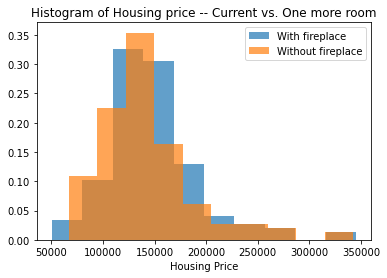

In [23]:
# distribution comparison
plt.hist(cf.point_estimate, label="With fireplace", alpha=0.7, weights=np.ones(len(whatif_y)) / len(whatif_y))
plt.hist(whatif_y, label="Without fireplace", alpha=0.7, weights=np.ones(len(whatif_y)) / len(whatif_y))
plt.legend()
plt.xlabel("Housing Price")
plt.title("Histogram of Housing price -- Current vs. One more room")

From the summary table we could see overall if we add a fireplace to houses without fireplaces in the test set, the average housing price for those houses will increase by about \\$5k. And the histrogram shows a comparison between the current housing price distribution and the counterfactuals ditribution if we added a fireplace to the fireplace-less houses in the test set.

### Cohort Analysis -- What is the causal effect on a new dataset?
The CausalAnalysis class can also help us learn the global and local causal effect of a new dataset given a trained model. From the two tables below, you can see the global effect on the test set is similar to that of the training set. And calculating the local effect gives you the heterogeneous treatment effect for each observation.

In [24]:
# global effect on new dataset
ca.cohort_causal_effect(x_test)

,point,stderr,zstat,p_value,ci_lower,ci_upper
feature,,,,,,
HasFireplace,4671.279635,1513.279047,3.086859,0.002023,1705.307204,7637.252065
HasPorch,3909.396278,2226.272326,1.756028,0.079084,-454.017301,8272.809856
HasDeck,1601.703336,1847.107579,0.867141,0.385865,-2018.560995,5221.967667


In [25]:
# local effect on new dataset
ca.local_causal_effect(x_test)

point       stderr     zstat   p_value  \
sample feature                                                      
0      HasFireplace  6331.049372  2152.981275  2.940597  0.003276   
       HasPorch      3754.116519  2506.382424  1.497823  0.134179   
       HasDeck       2255.977196  2262.207339  0.997246  0.318645   
1      HasFireplace  5198.309205  3807.239983  1.365375  0.172135   
       HasPorch      3628.806037  6168.138440  0.588315  0.556321   
...                          ...          ...       ...       ...   
289    HasPorch      4498.704032  2717.315190  1.655569  0.097809   
       HasDeck       2220.621642  2236.743913  0.992792  0.320811   
290    HasFireplace  2767.218269  2766.746829  1.000170  0.317228   
       HasPorch      5268.966977  5010.331709  1.051620  0.292974   
       HasDeck       2184.046930  4012.624558  0.544294  0.586239   

                        ci_lower      ci_upper  
sample feature                                  
0      HasFireplace  2111.283613  10550.815131  
       HasPorch     -1158.302764   8666.535801  
       HasDeck      -2177.867715   6689.822106  
1      HasFireplace -2263.744042  12660.362452  
       HasPorch     -8460.523157  15718.135231  
...                          ...           ...  
289    HasPorch      -827.135875   9824.543938  
       HasDeck      -2163.315870   6604.559153  
290    HasFireplace -2655.505870   8189.942409  
       HasPorch     -4551.102724  15089.036677  
       HasDeck      -5680.552687  10048.646548  

[873 rows x 6 columns]